# Creating artificial clustered trajectories

## TODO

- Allow for along-track scale variability (can be used to, e.g., keep start or end points fixed).
- Use clustering algorithm for diagnosing clusters again.
- Find out how to best use (known) centroids for distance-based or similarity-based classification.

## Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
np.random.seed(123)

## Functions to build trajectories

Here's a few functions that we can use to create and morph trajectories.

In [3]:
def create_smooth_traj(number_steps=100, smooth_length=11):
    window = np.hanning(smooth_length)
    window /= window.sum()
    
    return pd.DataFrame({
        "x": np.convolve(
            np.random.normal(size=(number_steps + smooth_length - 1, )),
            window,
            mode="valid",
        ).cumsum(),
        "y": np.convolve(
            np.random.normal(size=(number_steps + smooth_length - 1, )),
            window,
            mode="valid",
        ).cumsum(),
    })

In [4]:
def create_traj_from_to(
    start_x=0, 
    start_y=0, 
    end_x=1, 
    end_y=1, 
    number_steps=100,
):
    return pd.DataFrame({
        "x": np.linspace(start_x, end_x, number_steps),
        "y": np.linspace(start_y, end_y, number_steps),
    })

## Functions to morph in trajectory-attached coordinate system

In [5]:
def get_local_coord_system(traj):
    
    # forward and backward (incoming diff)
    fwd = - traj.diff(periods=-1).add_prefix("d")
    bwd = traj.diff(periods=1).add_prefix("d")

    # symmetric direction
    # Note how we don't normalise before addition. Hence, larger steps have
    # a stronger influence on the symmetric direction of the trajectory.
    symm = fwd.add(bwd, axis=1) # / 2
    symm = symm.where(~symm.isnull(), fwd.fillna(0).add(bwd.fillna(0), axis=0))

    # normalize along-track directions
    symm = symm.div(symm.apply(lambda row: sum(row ** 2) ** 0.5, axis=1), axis=0)

    # rename
    symm = symm.rename(columns={"dx": "e1x", "dy": "e1y"})

    # add cross-track vector
    symm["e2x"] = symm["e1y"]
    symm["e2y"] = - symm["e1x"]

    return symm

In [6]:
def modify_trajectory(traj=None, along_shifts=None, across_shifts=None):
    directions = get_local_coord_system(traj) 
    mod_along = directions.filter(like="e1").mul(along_shifts, axis=0)
    mod_across = directions.filter(like="e2").mul(across_shifts, axis=0)
    mod_total = mod_along + mod_across.to_numpy()
    return traj + mod_total.to_numpy()

In [7]:
def get_shifts(length=None, scale=1):
    return pd.Series(
        data=np.random.normal(0, scale, size=(length, ))
    )

In [8]:
def get_smooth_shifts(traj=None, scale=1, smooth_length=1):
    window = np.hanning(smooth_length)
    window /= window.sum()
    shifts = get_shifts(length=len(traj) + smooth_length - 1, scale=scale)
    return pd.Series(
        data=np.convolve(
            shifts,
            window,
            mode="valid"
        )
    )

## Here's what's happening

In [9]:
traj = create_smooth_traj(number_steps=7, smooth_length=6)

In [10]:
directions = get_local_coord_system(traj)
directions

,e1x,e1y,e2x,e2y
0,-0.483439,0.875378,0.875378,0.483439
1,-0.244289,0.969703,0.969703,0.244289
2,-0.177920,0.984045,0.984045,0.177920
3,-0.397971,0.917398,0.917398,0.397971
4,-0.426636,0.904423,0.904423,0.426636
5,-0.108018,0.994149,0.994149,0.108018
6,-0.011864,0.999930,0.999930,0.011864


In [11]:
along_shifts = get_smooth_shifts(traj=traj, scale=0.5, smooth_length=7)
across_shifts = get_smooth_shifts(traj=traj, scale=0.5, smooth_length=7)

In [12]:
shifts = pd.DataFrame({
    "along": along_shifts,
    "across": across_shifts,
})

In [13]:
traj_morphed = modify_trajectory(
    traj=traj, 
    along_shifts=along_shifts,
    across_shifts=across_shifts
)

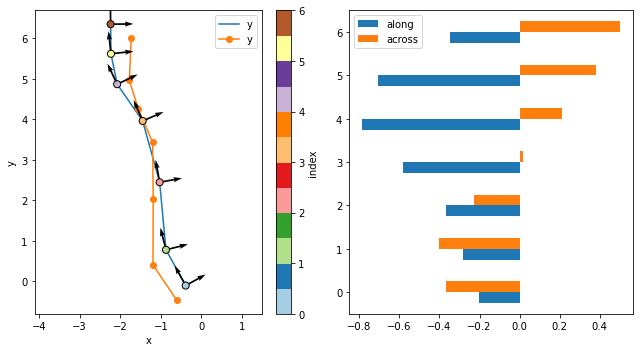

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))

traj.plot.line(x="x", y="y", ax=ax[0])
traj.reset_index().plot.scatter(
    x="x", y="y", marker="o",
    s=50, c="index", cmap="Paired",
    edgecolor="k",
    zorder=100,
    ax=ax[0],
);
ax[0].quiver(traj["x"], traj["y"], directions["e1x"], directions["e1y"], scale=10, zorder=99)
ax[0].quiver(traj["x"], traj["y"], directions["e2x"], directions["e2y"], scale=10, zorder=99)

traj_morphed.plot.line(
    x="x", y="y", marker="o",
    ax=ax[0]
);
ax[0].axis('equal');

shifts.plot.barh(ax=ax[1])

fig.tight_layout();

## Now create clusters of trajectories

In [15]:
number_clusters = 8
number_members = 25
traj_lengths = 100

In [16]:
centroids = {
    n: create_smooth_traj(number_steps=traj_lengths, smooth_length=41)
    for n in range(number_clusters)
}

In [17]:
clusters = pd.concat({
    n: pd.concat({
        m: modify_trajectory(
            traj=c, 
            along_shifts=get_smooth_shifts(traj=c, smooth_length=31, scale=1),
            across_shifts=get_smooth_shifts(traj=c, smooth_length=31, scale=2)
        )
        for m in range(number_members)
    }, axis=0)
    for n, c in centroids.items()
}, axis=0)

# there's probably a better way for this:
clusters.index = clusters.index.set_names(["cluster", "member", "step"])

In [18]:
clusters

x         y
cluster member step                     
0       0      0     -0.212681  0.016427
               1     -0.298452  0.045336
               2     -0.404488  0.036996
               3     -0.523602 -0.003250
               4     -0.647655 -0.078120
...                        ...       ...
7       24     95    12.303216 -0.801736
               96    12.610659 -0.567098
               97    12.910140 -0.339776
               98    13.203069 -0.124611
               99    13.488702  0.077476

[20000 rows x 2 columns]

In [19]:
centroids = pd.concat(centroids, axis=0)
centroids.index = centroids.index.set_names(["cluster", "step"])

In [20]:
centroids

x         y
cluster step                     
0       0     -0.029879 -0.009245
        1     -0.089299 -0.032166
        2     -0.173788 -0.073425
        3     -0.278810 -0.137124
        4     -0.399193 -0.226894
...                 ...       ...
7       95    12.036740 -0.743244
        96    12.326173 -0.516949
        97    12.614303 -0.293051
        98    12.900788 -0.070313
        99    13.185219  0.152590

[800 rows x 2 columns]

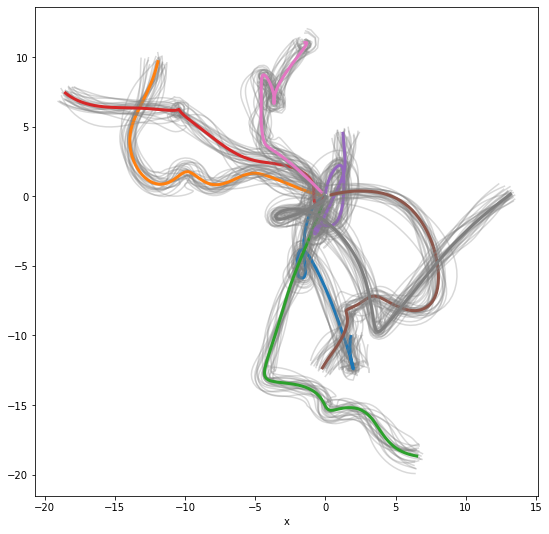

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for c in centroids.index.get_level_values("cluster").unique():
    for m in clusters.loc[c].index.get_level_values("member").unique():
        clusters.loc[c].loc[m].plot.line(
            x="x", y="y", color="gray", alpha=0.3, ax=ax, legend=False, label=None
        )
    centroids.loc[c].plot.line(
        x="x", y="y", ax=ax, linewidth=3, label=f"cluster {c}", legend=None
    )